In [51]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils import data
import os
import matplotlib.pyplot as plt


In [23]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [24]:
full_data = datasets.ImageFolder(root=('data/train'))
full_data

Dataset ImageFolder
    Number of datapoints: 1494
    Root location: data/train

In [25]:
train_size = int(0.8 * len(full_data))
val_size = len(full_data) - train_size

In [26]:
train_size + val_size == len(full_data)

True

In [27]:
train_subset, val_subset = data.random_split(full_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))

In [28]:
train_subset.dataset.transform = train_transform
val_subset.dataset.transform = val_transform

In [29]:
num_workers = os.cpu_count()
num_workers

10

In [30]:
train_loader = data.DataLoader(train_subset, batch_size=64, num_workers=num_workers, shuffle=True)
test_loader = data.DataLoader(val_subset, batch_size=64, num_workers=num_workers, shuffle=False)

/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

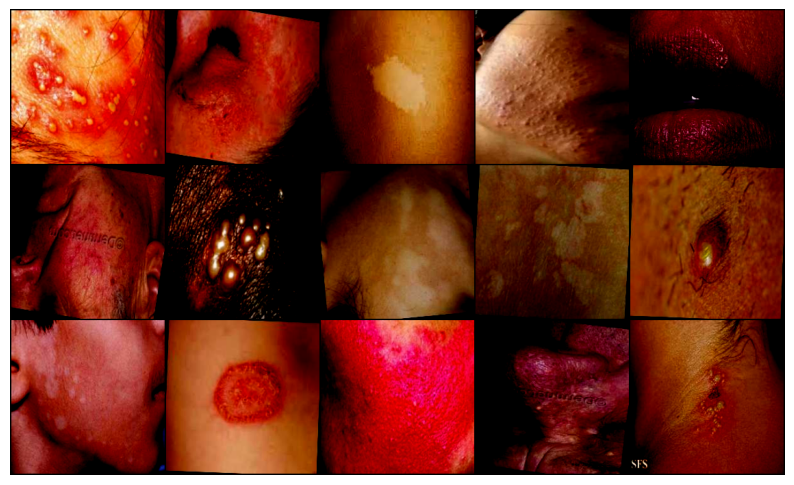

In [31]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(10, 8))
plt.imshow(make_grid(images[:15], nrow=5).permute(1, 2, 0))
plt.axis("off")
plt.show()

In [32]:
device = 'mps' if torch.mps.is_available() else 'cpu'
device

'mps'

In [33]:
class VGGArchitecture(nn.Module):
    def __init__(self, input, hidden, output):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*56*56, out_features=output)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x

In [34]:
num_classes = len(full_data.classes)
num_classes

5

In [35]:
model_0 = VGGArchitecture(input=3, hidden=64, output=num_classes).to(device)
model_0

VGGArchitecture(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=5, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=1e-3)

In [37]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 10

for epoch in range(epochs):
    model_0.train()
    for X, y in train_loader:
        X = X.to(device)
        y = torch.tensor(y, dtype=torch.long).to(device)
        y_train_logits = model_0(X)
        train_loss = criterion(y_train_logits, y)
        y_train_preds = torch.softmax(y_train_logits, dim=1).argmax(dim=1)
        train_accuracy = (y_train_preds == y).float().mean()
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        for X, y in test_loader:
            X = X.to(device)
            y = torch.tensor(y, dtype=torch.long).to(device)
            y_test_logits = model_0(X)
            test_loss = criterion(y_test_logits, y)
            y_test_preds = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
            test_accuracy = (y_test_preds == y).float().mean()

    print(f"Epoch: {epoch} || Train Loss: {train_loss} || Test Loss: {test_loss} || Train Accuracy: {train_accuracy} || Test Accuracy: {test_accuracy}")


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 0 || Train Loss: 1.6092056035995483 || Test Loss: 1.6096725463867188 || Train Accuracy: 0.1627907007932663 || Test Accuracy: 0.302325576543808


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 1 || Train Loss: 1.6088886260986328 || Test Loss: 1.6117600202560425 || Train Accuracy: 0.1860465109348297 || Test Accuracy: 0.13953489065170288


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 2 || Train Loss: 1.6049861907958984 || Test Loss: 1.6125197410583496 || Train Accuracy: 0.23255814611911774 || Test Accuracy: 0.13953489065170288


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 3 || Train Loss: 1.6164343357086182 || Test Loss: 1.610273838043213 || Train Accuracy: 0.1860465109348297 || Test Accuracy: 0.13953489065170288


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 4 || Train Loss: 1.5978730916976929 || Test Loss: 1.6114739179611206 || Train Accuracy: 0.3720930218696594 || Test Accuracy: 0.13953489065170288


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 5 || Train Loss: 1.6011171340942383 || Test Loss: 1.6104601621627808 || Train Accuracy: 0.25581395626068115 || Test Accuracy: 0.13953489065170288


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 6 || Train Loss: 1.601003646850586 || Test Loss: 1.609720230102539 || Train Accuracy: 0.1860465109348297 || Test Accuracy: 0.13953489065170288


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 7 || Train Loss: 1.6137582063674927 || Test Loss: 1.6078718900680542 || Train Accuracy: 0.20930232107639313 || Test Accuracy: 0.1860465109348297


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 8 || Train Loss: 1.6069176197052002 || Test Loss: 1.6060773134231567 || Train Accuracy: 0.13953489065170288 || Test Accuracy: 0.27906978130340576


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 9 || Train Loss: 1.6004163026809692 || Test Loss: 1.6055446863174438 || Train Accuracy: 0.302325576543808 || Test Accuracy: 0.25581395626068115


In [38]:
model_0.eval()
images, labels = next(iter(train_loader))
outputs = model_0(images.to(device))

print(outputs.argmax(dim=1)[:10])
print(labels[:10])

/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

tensor([3, 3, 3, 3, 4, 3, 3, 3, 3, 3], device='mps:0')
tensor([0, 1, 3, 0, 2, 4, 2, 3, 3, 0])


In [46]:
class Model_1(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

In [47]:
model_1 = Model_1().to(device)
model_1

Model_1(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=1e-3)

In [49]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 10

for epoch in range(epochs):
    model_1.train()
    for X, y in train_loader:
        X = X.to(device)
        y = torch.tensor(y, dtype=torch.long).to(device)
        y_train_logits = model_1(X)
        train_loss = criterion(y_train_logits, y)
        y_train_preds = torch.softmax(y_train_logits, dim=1).argmax(dim=1)
        train_accuracy = (y_train_preds == y).float().mean()
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        for X, y in test_loader:
            X = X.to(device)
            y = torch.tensor(y, dtype=torch.long).to(device)
            y_test_logits = model_1(X)
            test_loss = criterion(y_test_logits, y)
            y_test_preds = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
            test_accuracy = (y_test_preds == y).float().mean()

    print(f"Epoch: {epoch} || Train Loss: {train_loss} || Test Loss: {test_loss} || Train Accuracy: {train_accuracy} || Test Accuracy: {test_accuracy}")


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 0 || Train Loss: 1.3825197219848633 || Test Loss: 1.470324158668518 || Train Accuracy: 0.3488371968269348 || Test Accuracy: 0.39534884691238403


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 1 || Train Loss: 1.4808440208435059 || Test Loss: 1.3964346647262573 || Train Accuracy: 0.41860464215278625 || Test Accuracy: 0.4651162922382355


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 2 || Train Loss: 1.2368800640106201 || Test Loss: 1.4376384019851685 || Train Accuracy: 0.5581395626068115 || Test Accuracy: 0.4883720874786377


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 3 || Train Loss: 1.242518424987793 || Test Loss: 1.3427233695983887 || Train Accuracy: 0.5116279125213623 || Test Accuracy: 0.41860464215278625


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 4 || Train Loss: 1.1047067642211914 || Test Loss: 1.3516278266906738 || Train Accuracy: 0.5116279125213623 || Test Accuracy: 0.44186046719551086


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 5 || Train Loss: 1.23618745803833 || Test Loss: 1.389497995376587 || Train Accuracy: 0.4651162922382355 || Test Accuracy: 0.4651162922382355


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 6 || Train Loss: 1.0806934833526611 || Test Loss: 1.248568058013916 || Train Accuracy: 0.5813953280448914 || Test Accuracy: 0.4651162922382355


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 7 || Train Loss: 1.1331979036331177 || Test Loss: 1.3715075254440308 || Train Accuracy: 0.5581395626068115 || Test Accuracy: 0.5116279125213623


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 8 || Train Loss: 0.9737621545791626 || Test Loss: 1.1498955488204956 || Train Accuracy: 0.5581395626068115 || Test Accuracy: 0.39534884691238403


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch: 9 || Train Loss: 1.0761398077011108 || Test Loss: 1.261618733406067 || Train Accuracy: 0.5116279125213623 || Test Accuracy: 0.5348837375640869


In [50]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [52]:
num_classes = 5

model_2 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

model_2.fc = nn.Linear(model_2.fc.in_features, num_classes)

model = model_2.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/user/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 12.4MB/s]


In [53]:
for param in model_2.parameters():
    param.requires_grad = False

for param in model_2.fc.parameters():
    param.requires_grad = True

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.fc.parameters(), lr=1e-3)

In [55]:
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

outputs = model_2(images)
print(outputs.shape)

/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

torch.Size([64, 5])


In [56]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), correct / total

In [58]:
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total

In [59]:
epochs = 5

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(
        model_2, train_loader, criterion, optimizer
    )
    val_loss, val_acc = validate(
        model_2, test_loader, criterion
    )

    print(
        f"Epoch {epoch+1} | "
        f"Train Acc: {train_acc:.3f} | "
        f"Val Acc: {val_acc:.3f}"
    )

/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch 1 | Train Acc: 0.324 | Val Acc: 0.495


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch 2 | Train Acc: 0.572 | Val Acc: 0.632


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch 3 | Train Acc: 0.651 | Val Acc: 0.676


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch 4 | Train Acc: 0.690 | Val Acc: 0.689


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

Epoch 5 | Train Acc: 0.725 | Val Acc: 0.696


In [60]:
for param in model_2.layer4.parameters():
    param.requires_grad = True

In [61]:
optimizer = torch.optim.Adam( filter(lambda p: p.requires_grad, model_2.parameters()), lr=1e-4)

In [62]:
epochs = 10

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(
        model_2, train_loader, criterion, optimizer
    )
    val_loss, val_acc = validate(
        model_2, test_loader, criterion
    )

    print(
        f"[FT] Epoch {epoch+1} | "
        f"Train Acc: {train_acc:.3f} | "
        f"Val Acc: {val_acc:.3f}"
    )

/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

[FT] Epoch 1 | Train Acc: 0.805 | Val Acc: 0.853


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

[FT] Epoch 2 | Train Acc: 0.982 | Val Acc: 0.896


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

[FT] Epoch 3 | Train Acc: 1.000 | Val Acc: 0.906


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

[FT] Epoch 4 | Train Acc: 1.000 | Val Acc: 0.903


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

[FT] Epoch 5 | Train Acc: 1.000 | Val Acc: 0.903


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

[FT] Epoch 6 | Train Acc: 1.000 | Val Acc: 0.906


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

[FT] Epoch 7 | Train Acc: 1.000 | Val Acc: 0.910


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

[FT] Epoch 8 | Train Acc: 1.000 | Val Acc: 0.906


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

[FT] Epoch 9 | Train Acc: 1.000 | Val Acc: 0.906


/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

[FT] Epoch 10 | Train Acc: 1.000 | Val Acc: 0.916
